# Titanic: Machine Learning from Disaster

## Imports and configurations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression

import joblib
from pathlib import Path

In [2]:
# Set default font
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/noto_sans_mono/NotoSansMono_SemiCondensed-SemiBold.ttf'
font_prop = fm.FontProperties(fname=font_path)

mpl.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.weight"] = 'semibold'

bold = 'extra bold'

sns.set(font=font_prop.get_name(), style='darkgrid')

In [3]:
random_state = 42

In [4]:
train_df = pd.read_csv('data/train.csv')
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
test_df = pd.read_csv('data/test.csv')
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [6]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
(train_df.isna().sum() / len(train_df) * 100).round(1).to_frame().style.background_gradient()

,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.900000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


In [8]:
train_df['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [9]:
train_df['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [10]:
train_df['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [11]:
train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [12]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [13]:
(test_df.isna().sum() / len(test_df) * 100).round(1).to_frame().style.background_gradient()

,0
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,20.600000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.200000
Cabin,78.200000


We will drop the `Cabin` column.

In [14]:
train_df.drop('Cabin', axis=1, inplace=True)

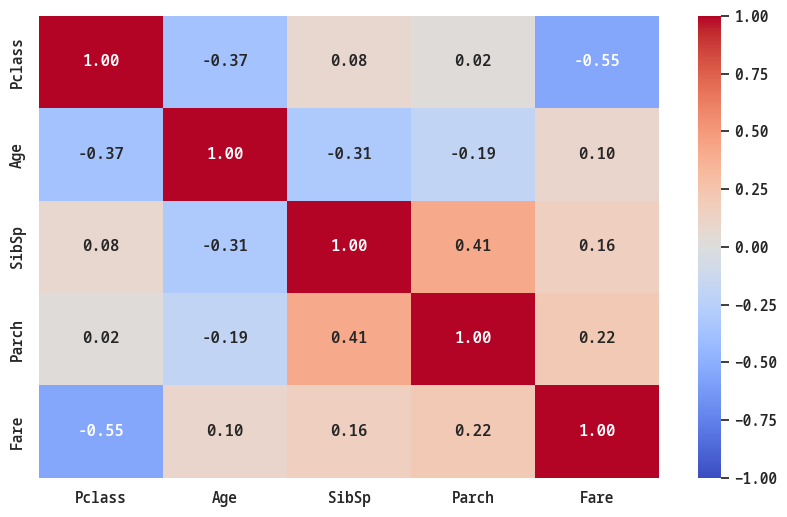

In [15]:
cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

plt.figure(figsize=(10, 6))

sns.heatmap(
        train_df[cols].corr(),
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        vmin=-1,
        vmax=1
        )

plt.show()

Let's try to impute the missing values in the `Age` column. Going with a simple median imputation for now. We could look into something more sophisticated in a future iteration since there is some correlation between age and some of the other features.

In [16]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())

In [17]:
titles = train_df['Name'].str.extract(r',\s(.*?)\.')[0]
titles.value_counts(dropna=False)

0
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [18]:
train_df['Title'] = np.where(
        titles.isin(['Mr', 'Miss', 'Mrs', 'Master']),
        titles,
        'Other'
        )

In [19]:
train_df['Title'].value_counts(dropna=False)

Title
Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: count, dtype: int64

In [20]:
train_df.drop(columns=['Name'], inplace=True)

In [21]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,S,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,211536,13.0000,S,Other
887,888,1,1,female,19.0,0,0,112053,30.0000,S,Miss
888,889,0,3,female,28.0,1,2,W./C. 6607,23.4500,S,Miss
889,890,1,1,male,26.0,0,0,111369,30.0000,C,Mr


Let's drop the ticket column, it doesn't seem to have information we can use.

In [22]:
train_df.drop('Ticket', axis=1, inplace=True)

Let's onehot encode the categorical columns to prepare for training.

In [23]:
train_df = pd.get_dummies(train_df,
                          columns=['Sex', 'Embarked', 'Title'],
                          drop_first=False).astype(float)

In [24]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

In [25]:
train_df

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,FamilySize
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887.0,0.0,2.0,27.0,0.0,0.0,13.0000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
887,888.0,1.0,1.0,19.0,0.0,0.0,30.0000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
888,889.0,0.0,3.0,28.0,1.0,2.0,23.4500,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0
889,890.0,1.0,1.0,26.0,0.0,0.0,30.0000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Let's put all of this into a class so we can reuse it later.

In [26]:
from preprocessing.preprocessor import Preprocessor

In [27]:
preprocessed = Preprocessor().transform(pd.read_csv('data/train.csv'))
preprocessed

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,FamilySize
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887.0,0.0,2.0,27.0,0.0,0.0,13.0000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
887,888.0,1.0,1.0,19.0,0.0,0.0,30.0000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
888,889.0,0.0,3.0,28.0,1.0,2.0,23.4500,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0
889,890.0,1.0,1.0,26.0,0.0,0.0,30.0000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [28]:
preprocessed.equals(train_df)

True

## Model training

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import metrics
import optuna
from datetime import datetime, timedelta
import humanize
from sklearn.tree import plot_tree

In [30]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_val, y_train, y_val = train_test_split(
        X,
        y,
        stratify=y,
        test_size=0.2,
        random_state=random_state
        )

In [33]:
def run_study(objective, n_trials=50, direction='maximize'):
    started_at = datetime.now()

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    ended_at = datetime.now()

    duration_in_seconds = (ended_at - started_at).total_seconds()

    print("Best parameters:", study.best_params)
    print("Best score:", study.best_value)
    print("Time taken:", humanize.naturaldelta(timedelta(seconds=duration_in_seconds)))

    return study, duration_in_seconds

In [34]:
def trial_evaluation_metric(y_true, y_pred):
#     return metrics.precision_score(y_true, y_pred)
    # return metrics.recall_score(y_true, y_pred)
    return metrics.f1_score(y_true, y_pred)
    # return metrics.fbeta_score(y_true, y_pred, beta=10)

In [35]:
def objective_dt(trial):
    params = {
            'max_depth': trial.suggest_int("max_depth", 1, 20),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 20),
            'criterion': trial.suggest_categorical("criterion", ["gini", "entropy"]),
            'random_state': random_state
            }

    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [36]:
def objective_rf(trial):
    params = {
            'n_estimators': trial.suggest_int("n_estimators", 10, 300),
            'max_depth': trial.suggest_int("max_depth", 1, 30),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 20),
            'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            'criterion': trial.suggest_categorical("criterion", ["gini", "entropy"]),
            'random_state': random_state
            }


    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [37]:
def objective_xgb(trial):
    params = {
            'n_estimators': trial.suggest_int("n_estimators", 50, 500),
            'max_depth': trial.suggest_int("max_depth", 3, 15),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            'subsample': trial.suggest_float("subsample", 0.5, 1.0),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
            'gamma': trial.suggest_float("gamma", 0, 5),
            'reg_alpha': trial.suggest_float("reg_alpha", 0, 10),
            'reg_lambda': trial.suggest_float("reg_lambda", 0, 10),
            'random_state': random_state,
            }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [38]:
dt_study, dt_execution_seconds = run_study(objective_dt, n_trials=50)

[I 2025-03-04 21:17:18,379] A new study created in memory with name: no-name-58515f9a-7e04-4ef0-80d0-12efdb387290


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-04 21:17:18,394] Trial 0 finished with value: 0.6111111111111112 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6111111111111112.
[I 2025-03-04 21:17:18,401] Trial 1 finished with value: 0.7669172932330827 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 1 with value: 0.7669172932330827.
[I 2025-03-04 21:17:18,409] Trial 2 finished with value: 0.7246376811594203 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 1 with value: 0.7669172932330827.
[I 2025-03-04 21:17:18,417] Trial 3 finished with value: 0.7424242424242424 and parameters: {'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 1 with value: 0.7669172932330827.
[I 2025-03-04 21:17:18,424] Trial 4 finished with value: 0.672566371681416 and parameters

[I 2025-03-04 21:17:19,031] Trial 40 finished with value: 0.7441860465116279 and parameters: {'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7669172932330827.
[I 2025-03-04 21:17:19,050] Trial 41 finished with value: 0.7611940298507462 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 1 with value: 0.7669172932330827.
[I 2025-03-04 21:17:19,069] Trial 42 finished with value: 0.7555555555555555 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 1 with value: 0.7669172932330827.
[I 2025-03-04 21:17:19,088] Trial 43 finished with value: 0.6111111111111112 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 1 with value: 0.7669172932330827.
[I 2025-03-04 21:17:19,108] Trial 44 finished with value: 0.6829268292682927 and par

In [39]:
rf_study, rf_execution_seconds = run_study(objective_rf, n_trials=50)

[I 2025-03-04 21:17:19,212] A new study created in memory with name: no-name-3ec2d388-0aa0-4baf-8567-92be25574184


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-04 21:17:19,338] Trial 0 finished with value: 0.75 and parameters: {'n_estimators': 97, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.75.
[I 2025-03-04 21:17:19,454] Trial 1 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 1 with value: 0.7692307692307693.
[I 2025-03-04 21:17:19,723] Trial 2 finished with value: 0.7559055118110236 and parameters: {'n_estimators': 250, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 1 with value: 0.7692307692307693.
[I 2025-03-04 21:17:19,907] Trial 3 finished with value: 0.7286821705426356 and parameters: {'n_estimators': 189, 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'crite

[I 2025-03-04 21:17:25,007] Trial 32 finished with value: 0.78125 and parameters: {'n_estimators': 109, 'max_depth': 26, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': None, 'criterion': 'entropy'}. Best is trial 28 with value: 0.796875.
[I 2025-03-04 21:17:25,080] Trial 33 finished with value: 0.796875 and parameters: {'n_estimators': 35, 'max_depth': 28, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None, 'criterion': 'entropy'}. Best is trial 28 with value: 0.796875.
[I 2025-03-04 21:17:25,158] Trial 34 finished with value: 0.7786259541984732 and parameters: {'n_estimators': 40, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': None, 'criterion': 'entropy'}. Best is trial 28 with value: 0.796875.
[I 2025-03-04 21:17:25,311] Trial 35 finished with value: 0.7846153846153846 and parameters: {'n_estimators': 88, 'max_depth': 26, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': None, 'criterion': 'entropy

In [40]:
xgb_study, xgb_execution_seconds = run_study(objective_xgb, n_trials=50)

[I 2025-03-04 21:17:27,004] A new study created in memory with name: no-name-eb42944b-281b-4051-909c-532d11170cbf


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-04 21:17:27,136] Trial 0 finished with value: 0.7286821705426356 and parameters: {'n_estimators': 328, 'max_depth': 5, 'learning_rate': 0.06909796341887009, 'subsample': 0.7321291850412419, 'colsample_bytree': 0.7701033563665325, 'gamma': 0.8785367562820534, 'reg_alpha': 5.525344934011709, 'reg_lambda': 3.665017288341015}. Best is trial 0 with value: 0.7286821705426356.
[I 2025-03-04 21:17:27,194] Trial 1 finished with value: 0.7230769230769231 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.033135493453229484, 'subsample': 0.7990110023707959, 'colsample_bytree': 0.5264814146216243, 'gamma': 2.5142670942856244, 'reg_alpha': 6.034310208774714, 'reg_lambda': 3.3559897048857392}. Best is trial 0 with value: 0.7286821705426356.
[I 2025-03-04 21:17:27,250] Trial 2 finished with value: 0.7286821705426356 and parameters: {'n_estimators': 147, 'max_depth': 3, 'learning_rate': 0.21445889706564528, 'subsample': 0.9769989897201465, 'colsample_bytree': 0.9205613

[I 2025-03-04 21:17:29,114] Trial 22 finished with value: 0.7538461538461538 and parameters: {'n_estimators': 402, 'max_depth': 13, 'learning_rate': 0.20837070486395348, 'subsample': 0.6771629846641625, 'colsample_bytree': 0.935471246425659, 'gamma': 3.8076604500495725, 'reg_alpha': 1.7569458103787716, 'reg_lambda': 0.9128022750861989}. Best is trial 12 with value: 0.7703703703703704.
[I 2025-03-04 21:17:29,233] Trial 23 finished with value: 0.7480916030534351 and parameters: {'n_estimators': 468, 'max_depth': 11, 'learning_rate': 0.12627710100687392, 'subsample': 0.624692587108884, 'colsample_bytree': 0.8927384473508889, 'gamma': 3.0324195195775476, 'reg_alpha': 3.121876396865531, 'reg_lambda': 0.7637762103974816}. Best is trial 12 with value: 0.7703703703703704.
[I 2025-03-04 21:17:29,383] Trial 24 finished with value: 0.7230769230769231 and parameters: {'n_estimators': 497, 'max_depth': 14, 'learning_rate': 0.010462637390517393, 'subsample': 0.557200684154145, 'colsample_bytree': 0.

[I 2025-03-04 21:17:31,409] Trial 45 finished with value: 0.7368421052631579 and parameters: {'n_estimators': 228, 'max_depth': 10, 'learning_rate': 0.17830766437619888, 'subsample': 0.7714851871771303, 'colsample_bytree': 0.8142764820070008, 'gamma': 3.9122876715642985, 'reg_alpha': 1.2399867691323507, 'reg_lambda': 1.8659208354982528}. Best is trial 12 with value: 0.7703703703703704.
[I 2025-03-04 21:17:31,511] Trial 46 finished with value: 0.75 and parameters: {'n_estimators': 186, 'max_depth': 8, 'learning_rate': 0.11678266529348168, 'subsample': 0.6330373767067073, 'colsample_bytree': 0.8779268859613517, 'gamma': 0.5374096696659643, 'reg_alpha': 0.47990214051098434, 'reg_lambda': 2.7629077933158515}. Best is trial 12 with value: 0.7703703703703704.
[I 2025-03-04 21:17:31,585] Trial 47 finished with value: 0.7131782945736435 and parameters: {'n_estimators': 144, 'max_depth': 14, 'learning_rate': 0.09196996368052539, 'subsample': 0.7138828888871039, 'colsample_bytree': 0.83868830261

In [41]:
# create a df with the results
df_results = pd.DataFrame({
    'model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'evaluation_metric': [
        dt_study.best_value,
        rf_study.best_value,
        xgb_study.best_value
        ],
    'execution_seconds': [
        dt_execution_seconds,
        rf_execution_seconds,
        xgb_execution_seconds
        ]
    })

In [42]:
df_results

,model,evaluation_metric,execution_seconds
0,Decision Tree,0.766917,0.829104
1,Random Forest,0.796875,7.788135
2,XGBoost,0.770370,4.778529


In [43]:
# calculate accuracy, precision, recall and f1-score
def calculate_metrics(model, X, y):
    y_pred = model.predict(X)

    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    f1 = metrics.f1_score(y, y_pred)

    return accuracy, precision, recall, f1

In [44]:
best_dt = DecisionTreeClassifier(**dt_study.best_params)
best_rf = RandomForestClassifier(**rf_study.best_params)
best_xgb = XGBClassifier(**xgb_study.best_params)

best_dt.fit(X_train, y_train)
best_rf.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)

print()

Save the models

In [45]:
joblib.dump(best_dt, 'models/best_dt.joblib')
joblib.dump(best_rf, 'models/best_rf.joblib')
joblib.dump(best_xgb, 'models/best_xgb.joblib')

['models/best_xgb.joblib']

In [46]:
# calculate metrics
dt_metrics = calculate_metrics(best_dt, X_val, y_val)
rf_metrics = calculate_metrics(best_rf, X_val, y_val)
xgb_metrics = calculate_metrics(best_xgb, X_val, y_val)

In [47]:
model_metrics = np.array([dt_metrics, rf_metrics, xgb_metrics]).transpose()
model_metrics

array([[0.82681564, 0.84357542, 0.82122905],
       [0.796875  , 0.83606557, 0.7761194 ],
       [0.73913043, 0.73913043, 0.75362319],
       [0.76691729, 0.78461538, 0.76470588]])

In [48]:
df_results['accuracy'] = model_metrics[0]
df_results['precision'] = model_metrics[1]
df_results['recall'] = model_metrics[2]
df_results['f1'] = model_metrics[3]

In [49]:
df_results

,model,evaluation_metric,execution_seconds,accuracy,precision,recall,f1
0,Decision Tree,0.766917,0.829104,0.826816,0.796875,0.739130,0.766917
1,Random Forest,0.796875,7.788135,0.843575,0.836066,0.739130,0.784615
2,XGBoost,0.770370,4.778529,0.821229,0.776119,0.753623,0.764706


Similar performance for all models.

In [50]:
def roc_curve_metrics(model, X, y):
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_proba)
    auc = metrics.roc_auc_score(y, y_pred_proba)

    return fpr, tpr, thresholds, auc

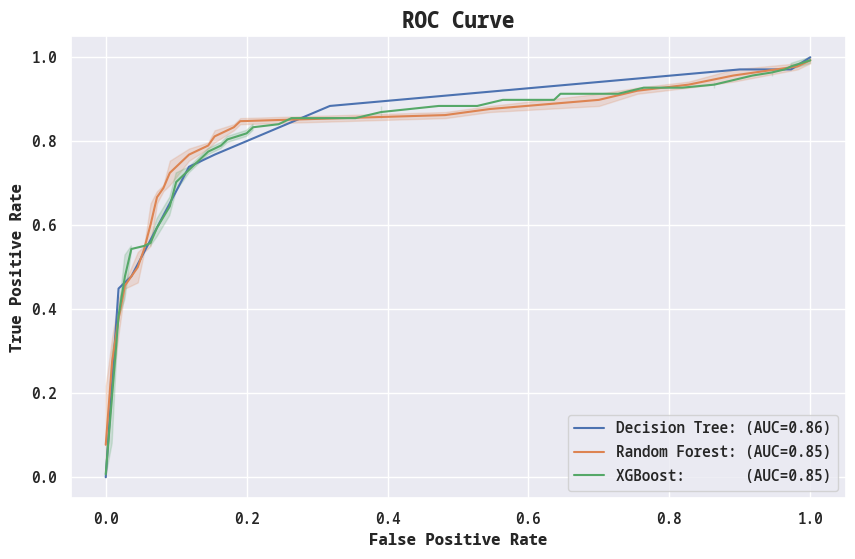

In [51]:
# plot auc with hue as model
fig, ax = plt.subplots(figsize=(10, 6))

viz_df = pd.DataFrame(columns=['model', 'fpr', 'tpr', 'auc', 'thresholds'])

max_legend_length = max([len(model + ': ') for model in df_results['model']])

fpr, tpr, thresholds, auc = roc_curve_metrics(best_dt, X_val, y_val)
sns.lineplot(x=fpr, y=tpr, ax=ax, label=f'Decision Tree: '.ljust(max_legend_length) + f'(AUC={auc:.2f})')

fpr, tpr, thresholds, auc = roc_curve_metrics(best_rf, X_val, y_val)
sns.lineplot(x=fpr, y=tpr, ax=ax, label=f'Random Forest: '.ljust(max_legend_length) + f'(AUC={auc:.2f})')

fpr, tpr, thresholds, auc = roc_curve_metrics(best_xgb, X_val, y_val)
sns.lineplot(x=fpr, y=tpr, ax=ax, label=f'XGBoost: '.ljust(max_legend_length) + f'(AUC={auc:.2f})')

ax.set_xlabel('False Positive Rate', fontweight=bold)
ax.set_ylabel('True Positive Rate', fontweight=bold)

plt.title('ROC Curve', fontweight=bold, fontsize=16)

plt.show()

Similar AUC for all models, 
<br />
We can use the decision tree model to also take advantage of the interpretability.

In [52]:
dt_study.best_params

{'max_depth': 3,
 'min_samples_split': 9,
 'min_samples_leaf': 7,
 'criterion': 'gini'}

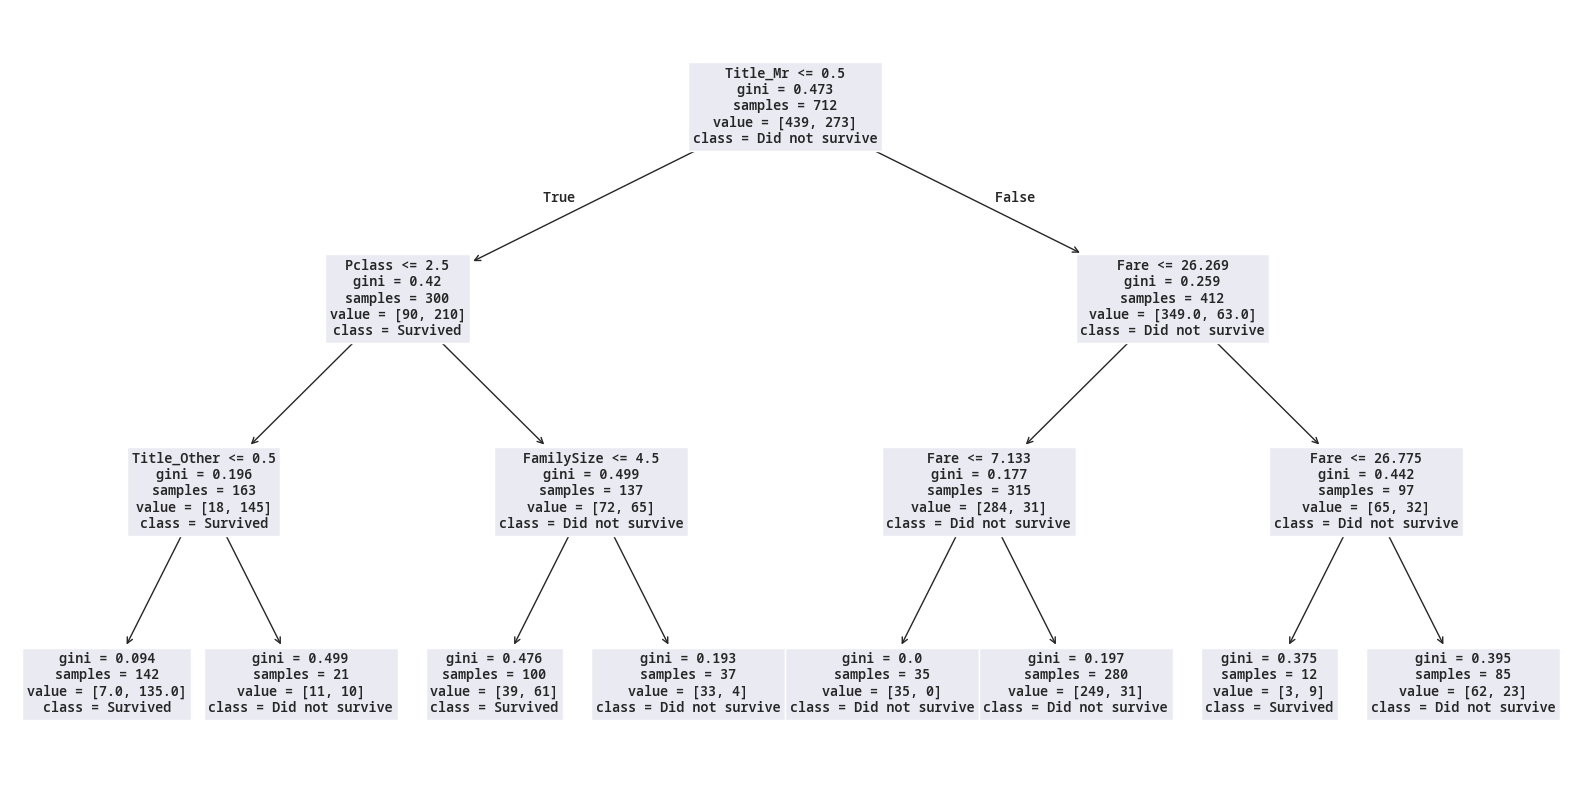

In [53]:
# print the tree

plt.figure(figsize=(20, 10))

plot_tree(
        best_dt,
        feature_names=X.columns,
        class_names=['Did not survive', 'Survived'],
        )

plt.show()

In [54]:
def color_confusion_matrix_annotations(cm, ax, i, j):
    # Get the colormap used in the plot
    cmap = ax.images[0].cmap
    norm = ax.images[0].norm

    # See https://github.com/scikit-learn/scikit-learn/blob/99bf3d8e4/sklearn/metrics/_plot/confusion_matrix.py#L159
    # print text with appropriate color depending on background
    thresh = (cm.max() + cm.min()) / 2.0

    cmap_max = cmap(norm(cm.max()))
    cmap_min = cmap(norm(cm.min()))

    color = cmap_max if cm[i, j] < thresh else cmap_min

    return color

In [55]:
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict(X)

    cm = metrics.confusion_matrix(y, y_pred)
    disp = metrics.ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=X.columns,
            )

    fig, ax = plt.subplots(
            nrows=1, ncols=1,
            figsize=(4, 3),
            dpi=200
            )

    disp = metrics.ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=['Did not survive', 'Survived'],
            )

    disp.plot(ax=ax, values_format='.0f', cmap='Oranges')

    # remove grid lines
    ax.grid(False)

    annotations = [
        ["True Negative", "False Positive"],
        ["False Negative", "True Positive"],
    ]

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i - 0.2,  # Slightly above the center
                annotations[i][j],
                ha="center", va="center",
                fontsize=9,
                color=color_confusion_matrix_annotations(cm, ax, i, j)
            )

    # change tick font size
    ax.tick_params(axis='both', which='major', labelsize=9)

    report = metrics.classification_report(y, y_pred, output_dict=True)
    metrics_df = pd.DataFrame(report).T.round(3)

    ax.set_title(type(model).__name__, fontweight=bold, fontsize=13)

    ax.set_xlabel('Predicted label', fontweight=bold)
    ax.set_ylabel('True label', fontweight=bold)

    plt.show()

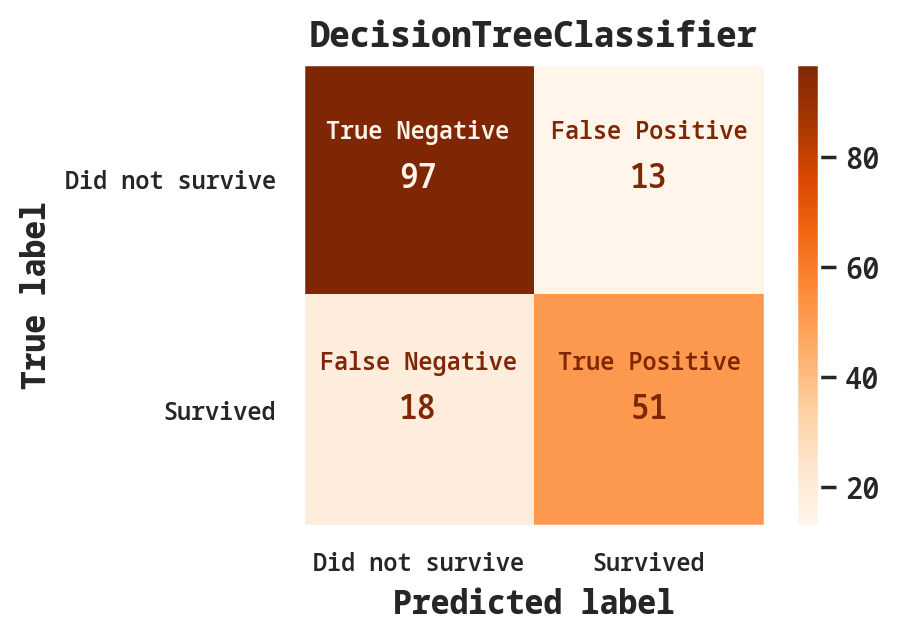

In [56]:
plot_confusion_matrix(best_dt, X_val, y_val)

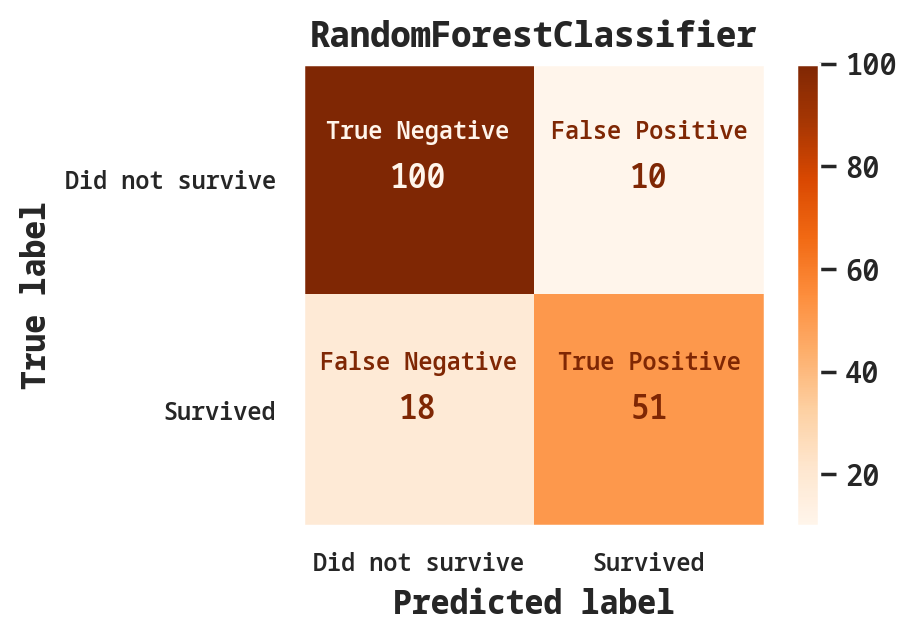

In [57]:
plot_confusion_matrix(best_rf, X_val, y_val)

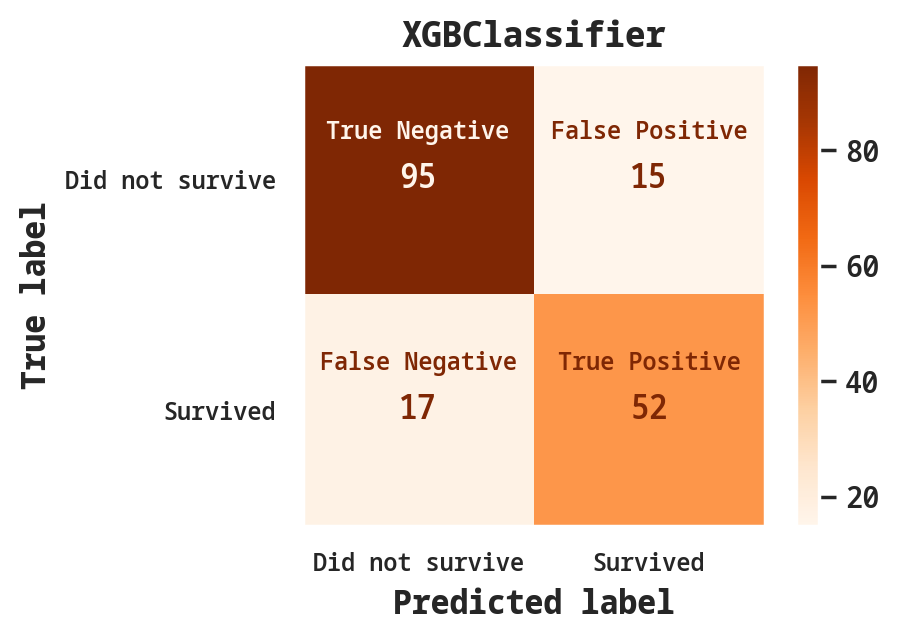

In [58]:
plot_confusion_matrix(best_xgb, X_val, y_val)

Similar performance for all models. We can use the decision tree model for its
interpretability.

Predict on the test set

In [59]:
preprocessor = Preprocessor()
X_test = preprocessor.transform(test_df)
y_pred = best_dt.predict(X_test)

In [60]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred
    })

In [61]:
submission['Survived'].value_counts()

Survived
0.0    251
1.0    167
Name: count, dtype: int64

In [63]:
submission['Survived'] = submission['Survived'].astype(int)

In [64]:
submission.to_csv('data/submission.csv', index=False)